# Preprocessing

Thema des Projektes ist die Teilnahme an der [Kagge-Challenge Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started), bei der mittels des Textes eines Tweets bestimmt werden soll, ob es sich um einen Tweet über eine reale Katastrophe oder einen Fake handelt. Dabei handelt es sich um ein Klassifikationsproblem, das mit Hilfe von maschinellem Lernen gelöst werden soll.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geograpy
import nltk
from sklearn import preprocessing
import re
from nltk.tokenize import WordPunctTokenizer
import string
import ast
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob

## Daten laden

### TODO: Herkunft des Datensatzes?

In [152]:
training_file = '../data/train.csv'
test_file = '../data/test.csv'

In [153]:
train = pd.read_csv(training_file, index_col=0)
test = pd.read_csv(test_file, index_col=0)
train.head()

keyword location                                               text  target
id                                                                            
1      NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
4      NaN      NaN             Forest fire near La Ronge Sask. Canada       1
5      NaN      NaN  All residents asked to 'shelter in place' are ...       1
6      NaN      NaN  13,000 people receive #wildfires evacuation or...       1
7      NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1

In [154]:
train.shape

(7613, 4)

In [155]:
test.shape

(3263, 3)

Der Datensatz hat 3 Features: 
* `text`: den Tweettext (`string`)
* `keyword`: Ein Keyword aus dem Tweet (`string`)
* `location`: Der Ort, aus dem der Tweet verschickt wurde. (`string`)

Zusätzlich gibt es im Trainingsdatensatz die Spalte `target` (`Boolean`)

Der Trainingsdatensatz umfasst 7613 Samples, der Test-Datensatz 3263.

In [156]:
print('Wahre Tweets: ' + str(train[train.target==1].shape[0]))
print('Falsche Tweets: ' + str(train[train.target==0].shape[0]))

Wahre Tweets: 3271
Falsche Tweets: 4342


Die Targets `0` für falschen Tweet und `1`für wahren Tweet sind mit 4342 zu 3271 Samples relativ ausgeglichen.

## Fehlstellen (NaNs) in Keyword und Location identifizieren und ersetzen

#### Fehlstellen im Trainigsdatensatz identifizieren

In [157]:
train.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

Im Trainingsdatensatz haben 61 Samples kein `keyword` und 2533 Samples keine `location`. `text`ist bei allen Samples vorhanden.

#### Fehlstellen im Testdatensatz identifizieren

In [158]:
test.isnull().sum()

keyword       26
location    1105
text           0
dtype: int64

Im Testdatensatz haben 26 Samples kein `keyword` und 1105 Samples keine `location`. `text`ist bei allen Samples vorhanden.

#### Fehlstellen ersetzen 
Wir wollen Fehlstellen bei `keyword` durch den Platzhalter `missing_keyword` ersetzen. Fehlstellen bei `location` sollen durch den Platzhalter `missing_location` ersetzt werden. 

In [159]:
for column in ['keyword', 'location']:
    train[column] = train[column].fillna(f'missing_{column}')
for column in ['keyword', 'location']:
    test[column] = test[column].fillna(f'missing_{column}')
    

## Duplikate

In [160]:
print("Trainingsdatensatz: Von insgesamt "+ str(len(train['text'])) +  " sind "+ str(len(train['text'].unique())) + " Tweets unique" )
print("Testdatensatz: Von insgesamt "+ str(len(test['text'])) +  " sind "+ str(len(test['text'].unique())) + " Tweets unique" )


Trainingsdatensatz: Von insgesamt 7613 sind 7503 Tweets unique
Testdatensatz: Von insgesamt 3263 sind 3243 Tweets unique


### Duplikate, die verschiedenes Target erhalten haben:
* hier 2 Targets -> Mislabelling

In [161]:
duplicate = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
print(duplicate)

                                                    keyword  location  target
text                                                                         
like for the music video I want some real actio...        2         1       2
Hellfire! We donÛªt even want to think about i...        1         2       2
The Prophet (peace be upon him) said 'Save your...        1         2       2
In #islam saving a person is equal in reward to...        1         2       2
To fight bioterrorism sir.                                1         1       2
...                                                     ...       ...     ...
Back from Seattle Tacoma and Portland. Whirlwin...        1         1       1
Baby elephant dies just days after surviving ma...        1         1       1
BUT I will be uploading these videos ASAP so yo...        1         1       1
BREAKING: Terror Attack On\nPolice Post #Udhampur         1         1       1
åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Tent...        1     

## Charakterisierung der Features

### Keyword 

In [162]:
print("Trainingsdatensatz: Von insgesamt "+ str(len(train['keyword'])) +  " sind "+ str(len(train['keyword'].unique())) + " Keywords unique" )
print("Testdatensatz: Von insgesamt "+ str(len(test['keyword'])) +  " sind "+ str(len(test['keyword'].unique())) + " Keywords unique" )


Trainingsdatensatz: Von insgesamt 7613 sind 222 Keywords unique
Testdatensatz: Von insgesamt 3263 sind 222 Keywords unique


#### Top 40 Keywords

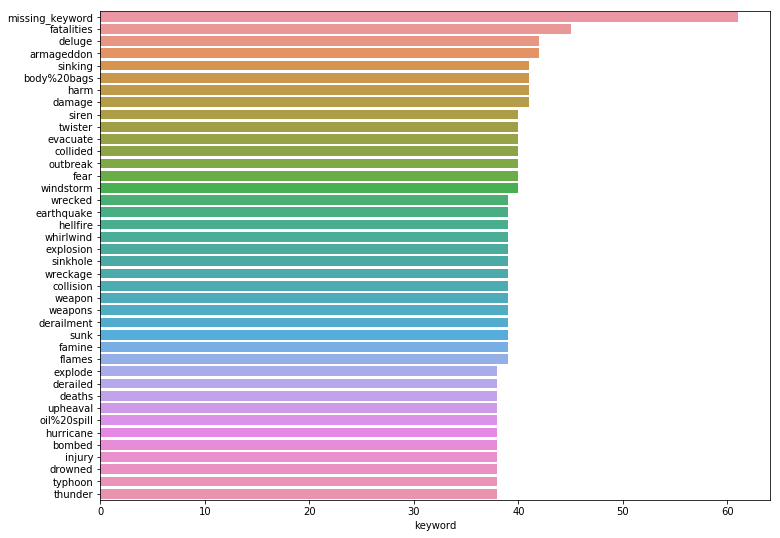

In [163]:
plt.figure(figsize=(12,9))
sns.barplot(x=train['keyword'].value_counts()[:40],y=train['keyword'].value_counts()[:40].index)

Das häufigste Vorkommen ist der Platzhalter `missing_keyword`. 

#### Top 40 Keywords Non-Disaster

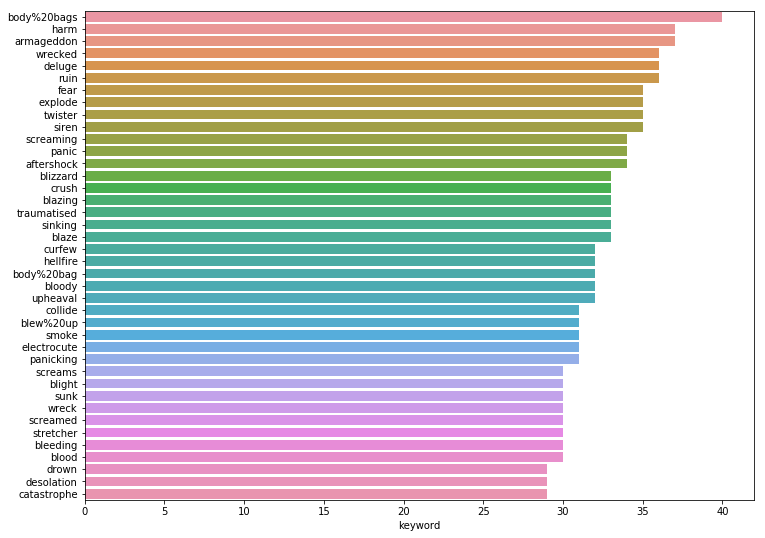

In [164]:
plt.figure(figsize=(12,9))
train_target0 = train[train["target"] == 0]
sns.barplot(x=train_target0['keyword'].value_counts()[:40],y=train_target0['keyword'].value_counts()[:40].index)

Bei den Top-40 Keywords der Tweets, die keine echte Katastrophe beschreiben, kommt der Platzhalter `missing_keyword` nicht vor. Die Keywords sind jedoch von vergleichbar dramatischem Inhalt, so dass davon keine Rückzüge auf die Klassifikation geschlossen werden können.

In [165]:
plt.figure(figsize=(12,9))
train_target1 = train[train["target"] == 1]
sns.barplot(x=train_target1['keyword'].value_counts()[:40],y=train_target1['keyword'].value_counts()[:40].index)

## Location 


#### Unique Locations

In [166]:
print("Trainingsdatensatz: Von insgesamt "+ str(len(train['location'])) +  " sind "+ str(len(train['location'].unique())) + " Locations unique" )
print("Testdatensatz: Von insgesamt "+ str(len(test['location'])) +  " sind "+ str(len(test['location'].unique())) + " Locations unique" )


Trainingsdatensatz: Von insgesamt 7613 sind 3342 Locations unique
Testdatensatz: Von insgesamt 3263 sind 1603 Locations unique


#### Top 100 Locations

In [167]:
plt.figure(figsize=(15,20))
sns.barplot(x=train_target1['location'].value_counts()[:100],y=train_target1['location'].value_counts()[:100].index)

Die Darstellung der Top-100-locations zeigt Schwierigkeiten mit diesem Feature auf. Zunächst gibt es sehr viele fehlende Werte. Der überwiegendende Wert ist `missing_location`. Von den restlichen Angaben haben die allermeisten sehr geringe Häufigkeiten. Viele kommen nur einmal vor. Das ist für statistische Analyse ungeeignet. 

Weiterhin sind die vorhandenen Ortsangaben nicht einheitlich. Teilweise werden Länder angegeben, teilweise Städte. Auch Schreibweisen sind uneinheitlich, z.B. ist sowohl der Wert `US` als auch `USA`, sowie `United Stattes` in den Daten zu finden. Auch handelt es sich bei einigen Ortsangaben nicht um tatsächliche Orte. Einige Beispiele dafür sind `MAD as Hell`, `Financial News and Views` oder `Inexpressible Island`.


#### Disaster Locations


In [168]:
plt.figure(figsize=(12,9))
train_target1 = train[train["target"] == 1]
sns.barplot(x=train_target1['location'].value_counts()[:40],y=train_target1['location'].value_counts()[:40].index)


#### Non Disaster Locations

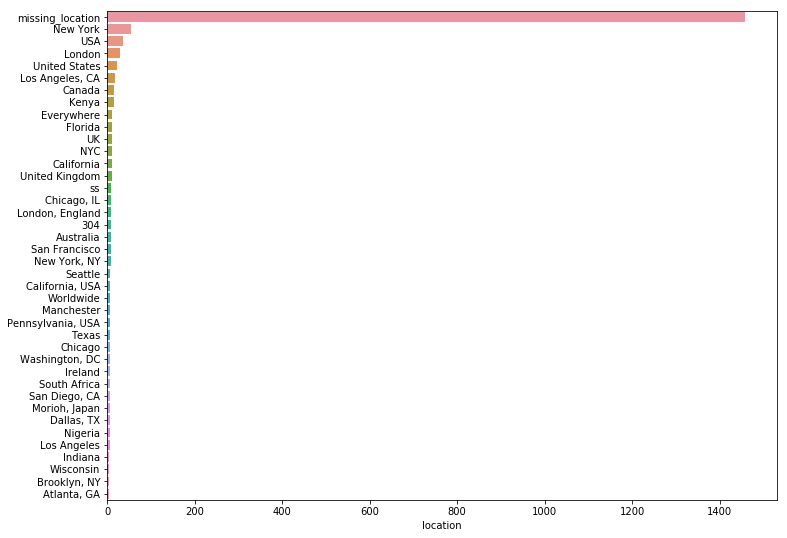

In [169]:
plt.figure(figsize=(12,9))
train_target0 = train[train["target"] == 0]
sns.barplot(x=train_target0['location'].value_counts()[:40],y=train_target0['location'].value_counts()[:40].index)


## Feature Engineering

Um die vorhandenen Daten für das maschinelle Lernen verwendebar zu machen, müssen alle Features, die nicht numerisch sind, in numerische Features umgewandelt werden. Dies betrifft alle Features unseres Datensatzes.

Zudem wollen wir aus dem Tweet-Text neue Features generieren, die wir für die Lösung des Klassifikationsproblems für geeignet halten.

Alle Transformationen führen wir auf dem Trainings- und dem Test-Datensatz durch.

### Umwandlung von Keyword und Location in numerische Features

`location` und `keyword` betrachten wir als kategoriale Features transformieren sie mittels eines LabelEncoders in Integers.

In [170]:
le = preprocessing.LabelEncoder()
train['keyword'] = le.fit_transform(train['keyword'].values)
train['location'] = le.fit_transform(train['location'].values)

test['keyword'] = le.fit_transform(test['keyword'].values)
test['location'] = le.fit_transform(test['location'].values)

### Tweet-spezifisches preprocessing

Bei Tweet handelt es sich um eine spezielle Textgattung mit Besonderheiten, die bei anderen Textarten nicht auftreten. Solche Besonderheiten sind beispielsweise das Häufige Vorkommen von URLs und Verlinkungen im Text, das Auftreten von Emojis und die Verwendung von Hashtags.

Diese Besonderheiten würden bei Standardverahren zur Tokenisierung und Vektorisierung von Text verloren gehen, da URLs dort bsp. einfach als Token (der nur einmal vorkommt) geparst werden würden. Wir vermuten, dass in diesen Informationen jedoch womöglich wichtige Hinweise auf die Echtheit von Tweets stecken können. Durch geeignetes Feature Engineering wollen wir diese Informationen als Features für das maschinelle Lernen verwendbar machen.

#### URLs

URLs sollen aus dem Tweet-Text entfernt werden und zunächst in einer eigenen Spalte für die spätere Weiterverarbeitung als Liste abgespeichert werden. 

In [171]:
def find_urls(tweet):
    urls = re.findall('https?://\S+|www\.\S+', tweet)
    return urls

def remove_urls_from_tweet(tweet):
    tweet = re.sub('https?://\S+|www\.\S+','', tweet)
    return tweet

In [172]:
train['urls'] = train.text.apply(find_urls)
train.text = train.text.apply(remove_urls_from_tweet)

test['urls'] = test.text.apply(find_urls)
test.text = test.text.apply(remove_urls_from_tweet)

URLs könnten dahingehend für die Klassifizierung als wahr oder fake dienen, dass wahre Tweets häufiger auf externe Quellen verweisen als falsche Tweets.

In [173]:
print('Wahre Tweets mit URLs: ' + str(train[train.target==1][train.urls.str.len()>0].shape[0]))
print('Falsche Tweets mit URLs: ' + str(train[train.target==0][train.urls.str.len()>0].shape[0]))

Wahre Tweets mit URLs: 2172
Falsche Tweets mit URLs: 1799


/Users/miriamamin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/miriamamin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Emojis

Auch Emojis sollen aus dem Tweet-Text entfernt und in einer eigenen Liste abgespeichert werden. 

In [174]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.findall(tweet)

In [175]:
train['emojis'] = train.text.apply(lambda x: remove_emoji(x))

test['emojis'] = test.text.apply(lambda x: remove_emoji(x))

In [176]:
train[train.emojis.str.len() > 0]

Empty DataFrame
Columns: [keyword, location, text, target, urls, emojis]
Index: []

In [177]:
test[test.emojis.str.len() > 0]

Empty DataFrame
Columns: [keyword, location, text, urls, emojis]
Index: []

Nach der Transformation müssen wir jedoch feststellen, dass es keine Emojis im Datensatz gibt, auch icht in `test`. 

#### Mentions 

Mentions auf Twitter sind Erwähnungen anderer User im Tweet-Text durch Verwendung des Zeichens `@`. Auch diese wollen wir aus dem Tweet-Text entfernen und in einer eigenen Spalte abspeichern.

In [178]:
def find_mentions(tweet):
    tweet = re.findall(r"(?:\@)\w+", tweet)
    return tweet
    
def remove_mentions(tweet):
    tweet = re.sub(r"(?:\@)\w+", '', tweet)
    return tweet

In [179]:
train['mentions'] = train.text.apply(find_mentions)
train.text = train.text.apply(remove_mentions)

test['mentions'] = test.text.apply(find_mentions)
test.text = test.text.apply(remove_mentions)

Auch hier könnte es einen Zusammenhang zwischen Wahrheit der im Tweet beschriebenen Katstrophe und den mentions geben. Beispielsweise wäre denkbar, dass offizielle Nachrichtenhäuser in ihren Berichten auf mentions verzichten, während humorvoll gemeinte Katastrophenberichte mit mentions der engen Freunde versehen sein könnten.

In [180]:
print('Wahre Tweets mit mentions: ' + str(train[train.target==1][train.mentions.str.len()>0].shape[0]))
print('Falsche Tweets mit mentions: ' + str(train[train.target==0][train.mentions.str.len()>0].shape[0]))

Wahre Tweets mit mentions: 665
Falsche Tweets mit mentions: 1342


/Users/miriamamin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/miriamamin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Hashtags

Im Gegensatz zu URLs, Emojis und Mentions wollen wir die Hashtags nicht vollständig aus dem Tweet-Text entfernen, da sie häufig grammatische Bestandteil des Satzes sind und sogar häufig die wichtigsten Inhaltswörter der Aussage mit einem Hashtag versehen sind. Um diese Wörter später mit den Mitteln der NLP verarbeiten zu können, entfernen wir nur das `#`-Symbol und speichern zudem die kompletten Hashtag als Liste in einer eigenen Spalte.

In [181]:
def find_hashtags(tweet):
    hashtags=re.findall(r"#\w+",tweet)
    return hashtags

def remove_hashtag(tweet):
    tweet = re.sub(r"#", '', tweet)
    return tweet

In [182]:
train['hashtags'] = train.text.apply(find_hashtags)
train.text = train.text.apply(remove_hashtag)

test['hashtags'] = test.text.apply(find_hashtags)
test.text = test.text.apply(remove_hashtag)

In [183]:
print('Wahre Tweets mit Hashtags: ' + str(train[train.target==1][train.hashtags.str.len()>0].shape[0]))
print('Falsche Tweets mit Hashtags: ' + str(train[train.target==0][train.hashtags.str.len()>0].shape[0]))

Wahre Tweets mit Hashtags: 858
Falsche Tweets mit Hashtags: 885


/Users/miriamamin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/miriamamin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Umwandlung von URLs, Emojis, Mentions und Hashtags in numerische Features

Um die in den vorhergehenden Schritten gewonnenen Informationen als Trainings-Feature für maschinelle Lernverfahren verwenden zu können, müssen wir auch diese in numerische Feature umwandeln. Wir entscheiden uns dafür bei allen Merkmalen für die Vorkommenshäufigkeit des Merkmals pro Tweet.

In [184]:
def get_count(x): 
    #x = ast.literal_eval(x) # parse string representation of list as actual list
    return len(x)

In [185]:
datasets = [train, test]
for dataset in datasets:
    dataset['cnt_emojis'] = dataset.emojis.apply(get_count)
    dataset['cnt_mentions'] = dataset.mentions.apply(get_count)
    dataset['cnt_hashtags'] = dataset.hashtags.apply(get_count)
    dataset['cnt_urls'] = dataset.urls.apply(get_count)

### Optionales weiteres Preprocessing

Falls die Ergebnisse später sehr unzufriedenstellend sind, gibt es einige weiter Preprocessing-Schritte, die die Performance ggf. verbessern könnten. Das wären z.B.:

* Digit removal
* Standardisierung der Ortsangaben
* Lemmatisierung
* Stopword removal

### Ideen nach Präsentation

#### Retweets


In [186]:
def find_num_retweets(tweet, retweets):
    return retweets.loc[tweet]

In [187]:
train_retweets = train['text'].value_counts()
train['num_retweets'] = train.text.apply(lambda x: find_num_retweets(x, train_retweets)-1)

test_retweets = test['text'].value_counts()
test['num_retweets'] = test.text.apply(lambda x: find_num_retweets(x, test_retweets)-1)

#### Sentiment

In [188]:
def get_sentiment(x):
    tb = TextBlob(x)
    return tb.sentiment.polarity

def get_subjectivity(x):
    tb = TextBlob(x)
    return tb.sentiment.subjectivity

In [189]:
train['sentiment'] = train.text.apply(get_sentiment)
train['subjectivity'] = train.text.apply(get_subjectivity)

In [190]:
test['sentiment'] = test.text.apply(get_sentiment)
test['subjectivity'] = test.text.apply(get_subjectivity)

In [191]:
train.to_csv('../data/base/train_base.csv')
test.to_csv('../data/base/test_base.csv')

### Feature-Statistik

In [206]:
train.head()

keyword  location                                               text  \
id                                                                         
1       145      3119  Our Deeds are the Reason of this earthquake Ma...   
4       145      3119             Forest fire near La Ronge Sask. Canada   
5       145      3119  All residents asked to 'shelter in place' are ...   
6       145      3119  13,000 people receive wildfires evacuation ord...   
7       145      3119  Just got sent this photo from Ruby Alaska as s...   

    target urls emojis mentions               hashtags  cnt_emojis  \
id                                                                   
1        1   []     []       []          [#earthquake]           0   
4        1   []     []       []                     []           0   
5        1   []     []       []                     []           0   
6        1   []     []       []           [#wildfires]           0   
7        1   []     []       []  [#Alaska, #wildfires]           0   

    cnt_mentions  cnt_hashtags  cnt_urls  num_retweets  sentiment  \
id                                                                  
1              0             1         0             0    0.00000   
4              0             0         0             0    0.10000   
5              0             0         0             0   -0.01875   
6              0             1         0             0    0.00000   
7              0             2         0             0    0.00000   

    subjectivity  
id                
1         0.0000  
4         0.4000  
5         0.3875  
6         0.0000  
7         0.0000

In [207]:
stat = train[['cnt_emojis', 'cnt_mentions', 'cnt_hashtags', 'cnt_urls', 'num_retweets']]
stat

cnt_emojis  cnt_mentions  cnt_hashtags  cnt_urls  num_retweets
id                                                                   
1               0             0             1         0             0
4               0             0             0         0             0
5               0             0             0         0             0
6               0             0             1         0             0
7               0             0             2         0             0
...           ...           ...           ...       ...           ...
10869           0             0             0         1             7
10870           0             2             0         0             1
10871           0             0             0         1             1
10872           0             0             0         0             1
10873           0             0             0         1            12

[7613 rows x 5 columns]

In [209]:
stat.describe()

cnt_emojis  cnt_mentions  cnt_hashtags     cnt_urls  num_retweets
count      7613.0   7613.000000   7613.000000  7613.000000   7613.000000
mean          0.0      0.356233      0.437410     0.620386      0.568239
std           0.0      0.714306      1.085629     0.664278      2.421869
min           0.0      0.000000      0.000000     0.000000      0.000000
25%           0.0      0.000000      0.000000     0.000000      0.000000
50%           0.0      0.000000      0.000000     1.000000      0.000000
75%           0.0      1.000000      0.000000     1.000000      0.000000
max           0.0      8.000000     13.000000     4.000000     23.000000

## Textvektorisierung

Es gibt verschiedene Methoden, Text in numerische Features zu transformieren. Wir wollen drei verschiedene Methoden testen und die selben Machine-Learning Methoden mit den daraus resultierenden 3 unterschiedlichen Datensätze trainieren.

Hinweis: die Ansätze die wir verwenden .. keine Tokenisierung notwendig

Unsere 3 Ansätze sind:
1. TF-IDF-Vektorisierung
2. WordEmbedding mit Word2Vec
3. BOW-Vektosisierung

### Dataset 1: TF-IDF-Vektorisierung

Bei der TF-IDF-Vektorisierung wird eine Dokumentensammlung transformiert in eine Matrix der TF-IDF-Gewichte jedes types in der Sammlung für jedes Dokument in der Sammlung.

Dazu nutzen wir die Klasse [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) aus dem Python-Paket sklearn. 

In [192]:
dataset_1_train = pd.read_csv('../data/base/train_base.csv')
dataset_1_test = pd.read_csv('../data/base/test_base.csv')

Damit die Gewichte gleich sind für `train` und `test` werden die beiden Datensätze zuerst zusammengefügt, dann der Vectorizer gefittet, die Dokumente transformiert und die Datensätze danach wieder getrennt.

In [193]:
# add empty target column to test in order to append the datasets
dataset_1_test['target'] = np.NaN 
# combine the datasets
dataset_combined = dataset_1_train.append(dataset_1_test, ignore_index=True) 

vectorizer = TfidfVectorizer(use_idf=True)
# fit vectorizer to combined data and get tf-idf matrix
tf=vectorizer.fit_transform(dataset_combined.text.values.astype('U')).toarray()

Aus der transformierten TF-IDF-Matrix entsteht der Datensatz für das maschinelle Lernen. Zusätzlich werden die numerischen Features aus den vorhergehenden Schritten hinzugefügt. Der finale Datensatz 1 hat also folgende Feature:

* TF-IDF-Features
* Anzahl Emojis
* Anzahl Mentions
* Anzhal Hashtags
* Anzahl URLs

In [194]:
# make new dataframe from the tf-idf-matrix
db_final=pd.DataFrame(data=tf)

# get back the rest of the transformed data
db_final['id']=dataset_combined['id']
db_final['location']=dataset_combined['location']
db_final['keyword']=dataset_combined['keyword']
db_final['cnt_emojis']=dataset_combined['cnt_emojis']
db_final['cnt_mentions']=dataset_combined['cnt_mentions']
db_final['cnt_hashtags']=dataset_combined['cnt_hashtags']
db_final['cnt_urls']=dataset_combined['cnt_urls']
db_final['num_retweets']=dataset_combined['num_retweets']
db_final['sentiment']=dataset_combined['sentiment']
db_final['subjectivity']=dataset_combined['subjectivity']
db_final['target'] = dataset_combined['target']

In [195]:
# separate datasets again
db_vectorized_train = db_final[0:7613]
db_vectorized_test = db_final[7613:]
db_vectorized_test = db_vectorized_test.drop('target', axis=1)

In [196]:
db_vectorized_test.head(100)

0    1    2    3    4    5    6    7    8    9  ...   id  location  \
7613  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0      1498   
7614  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    2      1498   
7615  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    3      1498   
7616  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    9      1498   
7617  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   11      1498   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
7708  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  323      1498   
7709  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  324      1498   
7710  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  325      1571   
7711  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  326      1498   
7712  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  333      1498   

      keyword  cnt_emojis  cnt_mentions  cnt_hashtags  cnt_urls  num_retweets  \
7613      145           0             0             0         0             0   
7614      145           0             0             1         0             0   
7615      145           0             0             0         0             0   
7616      145           0             0             2         0             0   
7617      145           0             0             0         0             0   
...       ...         ...           ...           ...       ...           ...   
7708        5           0             0             0         1             0   
7709        5           0             1             0         0             0   
7710        5           0             1             0         0             0   
7711        5           0             0             0         1             0   
7712        5           0             0             0         0             0   

      sentiment  subjectivity  
7613      -1.00          1.00  
7614       0.25          0.55  
7615       0.00          0.00  
7616       0.00          0.00  
7617       0.00          0.00  
...         ...           ...  
7708       0.60          0.80  
7709       0.00          0.00  
7710       0.00          0.00  
7711       0.00          0.00  
7712       0.00          0.00  

[100 rows x 18213 columns]

In [197]:
db_vectorized_train.to_csv('../data/dataset1/train_dataset1.csv', index=False)
db_vectorized_test.to_csv('../data/dataset1/test_dataset1.csv', index=False)

### Dataset 2: WordEmbedding with Word2Vec

Die Transformation der Dokumente mit WordEmbeddings befindet sich im Notebook 1b.

### Dataset 3: BOW-Vektorisierung

Bei der BOW-Vektorisierung wird eine Dokumentensammlung transformiert in eine Matrix der token counts.

Dazu nutzen wir die Klasse [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) aus dem Python-Paket sklearn. 

In [198]:
dataset_3_train = pd.read_csv('../data/base/train_base.csv')
dataset_3_test = pd.read_csv('../data/base/test_base.csv')

Die Vorgehensweise für die BOW-Transformation geschieht analog zur TF-IDF-Transformation.

In [199]:
# add empty target column to test in order to append the datasets
dataset_3_test['target'] = np.NaN 

# combine datasets
dataset_combined = dataset_3_train.append(dataset_3_test, ignore_index=True)

# fit CountVectorizer and transform text
count_vectorizer = CountVectorizer(ngram_range = (1,1), min_df = 1)
train_vectors = count_vectorizer.fit_transform(dataset_combined.text.values.astype('U')).toarray()

In [200]:
#make new dataframe from the bow-matrix
db_final=pd.DataFrame(data=train_vectors)
# get back the rest of the transformed data
db_final['id']=dataset_combined['id']
db_final['location']=dataset_combined['location']
db_final['keyword']=dataset_combined['keyword']
db_final['cnt_emojis']=dataset_combined['cnt_emojis']
db_final['cnt_mentions']=dataset_combined['cnt_mentions']
db_final['cnt_hashtags']=dataset_combined['cnt_hashtags']
db_final['cnt_urls']=dataset_combined['cnt_urls']
db_final['num_retweets']=dataset_combined['num_retweets']
db_final['sentiment']=dataset_combined['sentiment']
db_final['subjectivity']=dataset_combined['subjectivity']
db_final['target'] = dataset_combined['target']

In [201]:
# separate datasets again
db_vectorized_train = db_final[0:7613]
db_vectorized_test = db_final[7613:]
db_vectorized_test = db_vectorized_test.drop('target', axis=1)

In [202]:
db_vectorized_train.head(100)

0  1  2  3  4  5  6  7  8  9  ...  location  keyword  cnt_emojis  \
0   0  0  0  0  0  0  0  0  0  0  ...      3119      145           0   
1   0  0  0  0  0  0  0  0  0  0  ...      3119      145           0   
2   0  0  0  0  0  0  0  0  0  0  ...      3119      145           0   
3   0  1  0  0  0  0  0  0  0  0  ...      3119      145           0   
4   0  0  0  0  0  0  0  0  0  0  ...      3119      145           0   
.. .. .. .. .. .. .. .. .. .. ..  ...       ...      ...         ...   
95  0  0  0  0  0  0  0  0  0  0  ...       628        1           0   
96  0  0  0  0  0  0  0  0  0  0  ...       415        1           0   
97  0  0  0  0  0  0  0  0  0  0  ...      1091        1           0   
98  0  0  0  0  0  0  0  0  0  0  ...      1046        1           0   
99  0  0  0  0  0  0  0  0  0  0  ...      3119        1           0   

    cnt_mentions  cnt_hashtags  cnt_urls  num_retweets  sentiment  \
0              0             1         0             0   0.000000   
1              0             0         0             0   0.100000   
2              0             0         0             0  -0.018750   
3              0             1         0             0   0.000000   
4              0             2         0             0   0.000000   
..           ...           ...       ...           ...        ...   
95             0             0         0             0   0.142857   
96             0             0         0             0   0.000000   
97             1             3         0             0   0.150000   
98             1             0         0             0   0.000000   
99             0             0         0             0  -0.400000   

    subjectivity  target  
0       0.000000     1.0  
1       0.400000     1.0  
2       0.387500     1.0  
3       0.000000     1.0  
4       0.000000     1.0  
..           ...     ...  
95      0.267857     1.0  
96      0.000000     0.0  
97      0.450000     1.0  
98      0.000000     0.0  
99      0.866667     1.0  

[100 rows x 18214 columns]

In [203]:
db_vectorized_train.to_csv('../data/dataset3/train_dataset3.csv', index=False)
db_vectorized_test.to_csv('../data/dataset3/test_dataset3.csv', index=False)